In [1]:
# !pip install pandas
# !pip install watermark
# !pip install seaborn
# !pip install biopython|
# !pip install sklearn
import os
import re 
# from Bio import SeqIO
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np 
import watermark
import random 
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
left=3
right=9
signal_num=left+right

In [3]:
# 全局变量设定
signal_num = left+right
bases="ACGT"
lower_bases="acgt"
pattern = re.compile("[^acgt]")

In [4]:
output_name = "output/pomegranate"
train_features_df = pd.read_csv(f'{output_name}/Train_features.csv')
test_file_df = pd.read_csv(f"{output_name}/Test_predict.csv")
test_features_df = pd.read_csv(f"{output_name}/Test_features.csv")

In [5]:
train_p=train_features_df[train_features_df["Label"]==1]

In [6]:
random_num=2080
random_state=123123
train_n=train_features_df[train_features_df["Label"]==0].sample(random_num,random_state=random_state).reset_index(drop=True)
train_df = pd.concat([train_p,train_n])
train_df

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label
0,0,2,3,2,3,0,0,2,3,0,3,1,1
1,3,3,1,2,3,0,0,2,3,0,1,1,1
2,0,2,2,2,3,0,0,2,0,2,0,2,1
3,1,0,2,2,3,2,2,2,2,2,1,1,1
4,2,0,2,2,3,2,0,2,3,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,2,3,2,2,3,0,1,0,3,1,1,1,0
2076,0,2,0,2,3,2,1,0,2,1,0,0,0
2077,0,1,3,2,3,3,0,2,1,3,3,3,0
2078,3,3,2,2,3,3,0,0,2,0,2,0,0


In [7]:
train_p.iloc[:,:-1]

,-3,-2,-1,0,1,2,3,4,5,6,7,8
0,0,2,3,2,3,0,0,2,3,0,3,1
1,3,3,1,2,3,0,0,2,3,0,1,1
2,0,2,2,2,3,0,0,2,0,2,0,2
3,1,0,2,2,3,2,2,2,2,2,1,1
4,2,0,2,2,3,2,0,2,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2375,1,0,2,2,3,0,2,2,3,2,2,1
2376,0,0,2,2,3,0,0,2,3,2,2,1
2377,0,1,0,2,3,2,0,2,3,0,2,3
2378,2,0,0,2,3,2,0,2,3,1,1,2


In [8]:
test_fl_df = test_features_df.copy()

In [9]:
test_fl_df["Label"] = test_file_df["label"]

In [10]:
test_fl_df

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label
0,2,2,2,2,3,2,0,2,1,1,1,0,1
1,2,3,2,2,3,0,0,2,0,2,0,1,1
2,3,0,2,2,3,2,0,2,3,2,3,2,1
3,2,1,2,2,3,0,2,2,3,0,1,3,1
4,1,0,2,2,3,0,0,3,3,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151200,3,0,0,2,3,3,0,0,0,3,1,0,0
151201,0,3,0,2,3,2,2,1,1,3,0,1,0
151202,3,2,0,2,3,3,3,1,3,2,3,3,0
151203,3,1,3,2,3,3,0,3,2,3,2,2,0


## 贝叶斯网络

In [11]:
# from pgmpy.estimators import HillClimbSearch
# from pgmpy.estimators import BDeuScore, K2Score, BicScore
# hc = HillClimbSearch(train_df, scoring_method=BDeuScore(train_df ))
# best_model = hc.estimate()
# print(best_model.edges())

In [12]:
# !pip install pomegranate

In [13]:
from pomegranate import *   

In [33]:
# 创建模型
# donor_model=BayesianNetwork.from_samples(train_p.iloc[:,:-1],algorithm="exact") 
# pseudo_model=BayesianNetwork.from_samples(train_n.iloc[:,:-1],algorithm="exact")
donor_model=BayesianNetwork.from_samples(train_p.iloc[:,:-1],algorithm="exact") 


In [34]:
import pygraphviz
import networkx as nx
donor_model.structure

((1,), (6,), (1,), (), (3,), (7,), (3, 4), (3, 4, 6), (2,), (8,), (9,), (10,))

In [35]:
donor_model.plot(f"{output_name}/pdf")

In [36]:
pseudo_model=BayesianNetwork.from_samples(train_n.iloc[:,:-1],algorithm="exact")
pseudo_model.structure

((1,),
 (2,),
 (),
 (1, 2),
 (1, 2, 3),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (3, 4, 11),
 (3, 4))

In [37]:
pseudo_model.plot(f"{output_name}/pseudo.pdf")

In [38]:
test_p_array=np.array(test_fl_df[test_fl_df["Label"]==1].iloc[:,:-1].reset_index(drop=True))
test_n_array=np.array(test_fl_df[test_fl_df["Label"]==0].iloc[:,:-1].reset_index(drop=True))

In [39]:
p_donorscore=donor_model.probability(test_p_array)
n_donorscore=donor_model.probability(test_n_array)
p_pseudoscore=pseudo_model.probability(test_p_array)
n_pseudoscore=pseudo_model.probability(test_n_array)

In [42]:
def log_c(num,ex_mini=10e-15):
    if num == 0:
        return np.log(ex_mini)
    else:
        return np.log(num)
p_score= list(map(log_c,np.array(p_donorscore)/np.array(p_pseudoscore)))


In [43]:
n_score= list(map(log_c,np.array(n_donorscore)/np.array(n_pseudoscore)))
print(len(n_score))

149126


In [45]:
# BN_predict_scores =list(p_donorscore)+list(n_pseudoscore)

In [52]:
BN_predict_scores = p_score+n_score

In [53]:
len(BN_predict_scores)

151205

In [54]:
BN_test_labels= pd.read_csv(f"{output_name}/Test_predict.csv")["label"]

In [55]:
WAM_predict_scores = pd.read_csv("output/WAM(-4+6)/WAM_predict_scores.csv")["scores"]
WAM_test_labels   = pd.read_csv("output/WAM(-4+6)/WAM_predict_scores.csv")["labels"]

In [56]:
SVM_test_labels =pd.read_csv("output/SVMoutput/Test_predict.csv")['label']
# SVM_RBF_scores = pd.read_csv("SVMoutput/SVM_predict_scores.csv")['RBF']
SVM_linear_scores = pd.read_csv("output/SVMoutput/SVM_predict_scores.csv")['linear']
SVM_poly_scores = pd.read_csv("output/SVMoutput/SVM_predict_scores.csv")['poly']

In [57]:
test_labels = [WAM_test_labels,BN_test_labels,SVM_test_labels,SVM_test_labels]
test_scores = [WAM_predict_scores,BN_predict_scores,SVM_linear_scores,SVM_poly_scores]

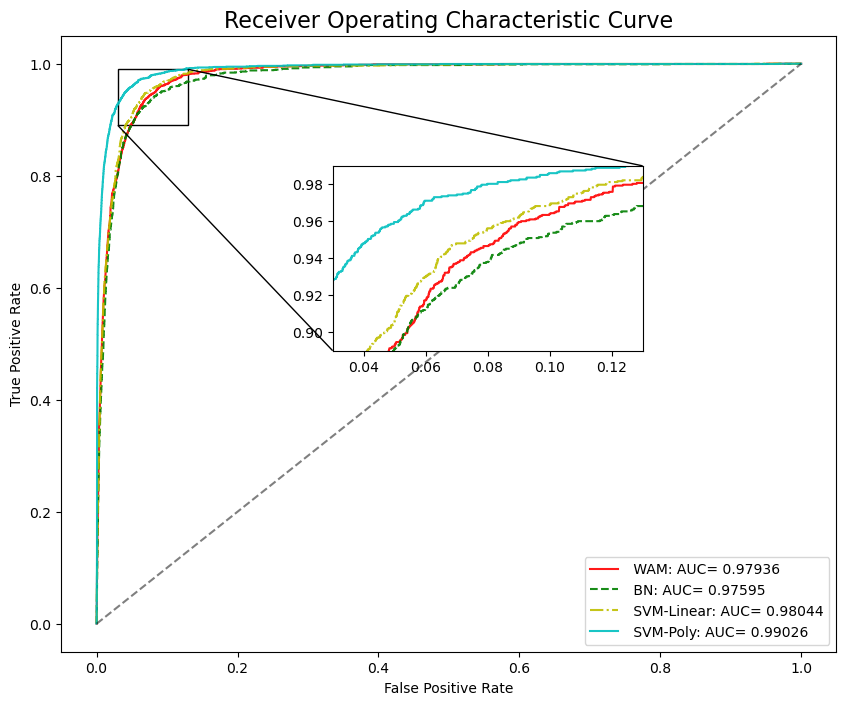

In [58]:
# ROC plot
# problem ： 如何画不同核的图在一个图里
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import matplotlib.pyplot as plt
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

def plot_roc(labels, predict_probs, titles):
    color = ['r', 'g', 'y','c','m']                                                                 
    linestyles = ['-','--','-.']
#     markers = ['v','o','p','+','1','D',',','.']
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    for idx, predict_prob in enumerate(predict_probs):
        fpr, tpr,thresholds=roc_curve(labels[idx], predict_prob)
        roc_auc=auc(fpr, tpr)
        if idx==1:
            optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
        c = color[idx%len(color)]                                                                     
        l =linestyles[idx%len(linestyles)]
#         m = markers [idx%len( markers )]
        ax.plot(fpr, tpr,'b',label=f' {titles[idx]}: AUC= {roc_auc:.5f}', color=c, linestyle=l, alpha=0.9,markevery=20)  
        ax.legend(loc='lower right')
    # 
    axins = inset_axes(ax, width="40%", height="30%",loc='upper center',
                   bbox_to_anchor=(0.05, -0.2, 1, 1),
                   bbox_transform=ax.transAxes)
    for idx, predict_prob in enumerate(predict_probs):
        false_positive_rate,true_positive_rate,thresholds=roc_curve(labels[idx], predict_prob)
        roc_auc=auc(false_positive_rate, true_positive_rate)
        c = color[idx%len(color)]                                                                     
        l =linestyles[idx%len(linestyles)]
        
#         m = markers [idx%len( markers )]
        axins.plot(false_positive_rate, true_positive_rate,'b', color=c, linestyle=l, alpha=0.9,markevery=20)  

    axins.set_xlim(0.03, 0.13)
    axins.set_ylim(0.89, 0.99)
    #
    mark_inset(ax, axins, loc1=3,loc2=1, fc="none", ec='k', lw=1)
    ax.plot([0,1],[0,1],'k--',alpha=0.5)
    ax.set_title("Receiver Operating Characteristic Curve",fontsize=16)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    ax.spines['left'].set_color('k')
    [axins.spines[loc_axis].set_color('k') for loc_axis in ['top','right','bottom','left']]
    plt.savefig(f'{output_name}/plot_ROC.png',dpi=120)
    plt.show()
    return optimal_th

plt.style.use('default')

optimal_th=plot_roc(test_labels,test_scores,titles=["WAM","BN","SVM-Linear","SVM-Poly"])



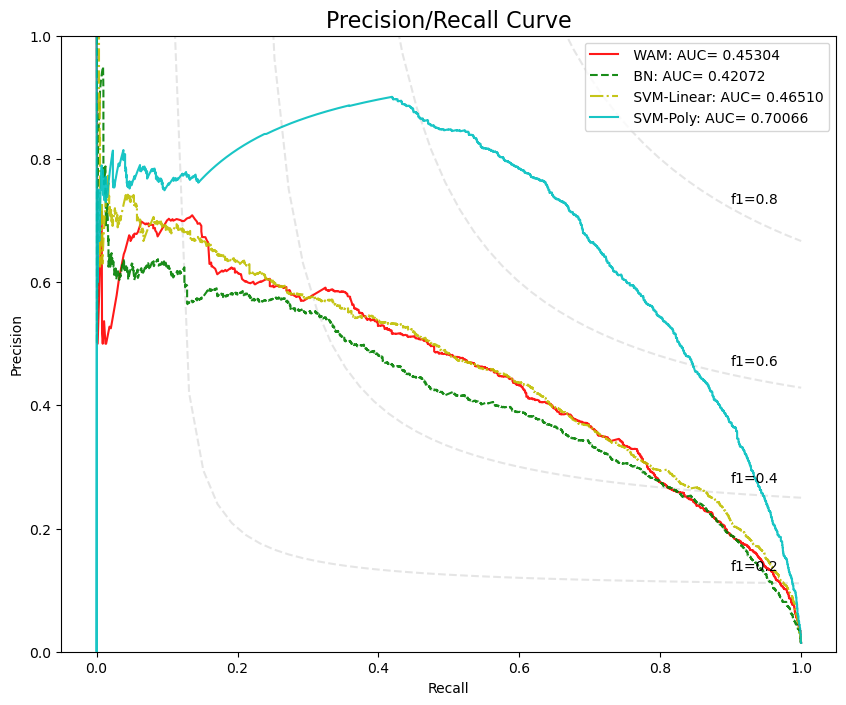

In [59]:
from sklearn.metrics import precision_recall_curve


# def plot_pr(labels, predict_probs):
#     plt.figure(figsize=(8, 6))
#     precision, recall, thresholds = precision_recall_curve(labels, predict_probs)
#     pr_auc=auc(recall, precision)
#     print(precision)
#     f_scores = np.linspace(0.2, 0.8, num=4)
#     for f_score in f_scores:
#         x = np.linspace(0.01, 1)
#         y = f_score * x / (2 * x - f_score)
#         l, = plt.plot(x[y >= 0], y[y >= 0], color='gray',linestyle='--' ,alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
#     plt.plot(recall,precision,'b',label=f'BN:AUC={pr_auc:.4f}', alpha=0.8,color="#135200")  
#     plt.legend(loc='lower right')
#     plt.plot([0,1],[1,0],'k--',alpha=0.5)
#     plt.title('Precision/Recall Curve',fontsize=16)# give plot a title
#     plt.xlabel('Recall')# make axis labels
#     plt.ylabel('Precision')
#     plt.ylim(0,1.05)
#     plt.legend(loc="upper right")
#     f = plt.gcf()  #获取当前图像
#     f.savefig(f'{output_name}/Plot_PR.png',dpi=120)
#     plt.show()
#     return thresholds
def plot_pr(labels, predict_probs, titles):
    color = ['r', 'g',  'y','c','m']                                                                 
    linestyles = ['-','--','-.']
    plt.figure(figsize=(10, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray',linestyle='--' ,alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    for idx, predict_prob in enumerate(predict_probs):
        precision, recall, thresholds = precision_recall_curve(labels[idx], predict_prob)
        pr_auc=auc(recall, precision)
        c = color[idx%len(color)]                                                                     

        l =linestyles[idx%len(linestyles)]
        plt.plot(recall,precision,'b',label=f' {titles[idx]}: AUC= {pr_auc:.5f}',color=c, linestyle=l, alpha=0.9,markevery=20)  
        plt.legend(loc='lower right')
    plt.ylim(0,1)
    # plt.plot([0,1],[1,0],color='gray',linestyle='--',alpha=0.5)
    plt.title('Precision/Recall Curve',fontsize=16)# give plot a title
    plt.xlabel('Recall')# make axis labels
    plt.ylabel('Precision')
    plt.legend(loc="upper right")
    f = plt.gcf()  
    f.savefig(f'{output_name}/plot_PR.png',dpi=120)
    plt.show()
plt.style.use('default')
thresholds=plot_pr(test_labels,test_scores,titles=["WAM","BN","SVM-Linear","SVM-Poly"])

# y_true = np.array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])
# y_scores = np.array([0.9, 0.75, 0.86, 0.47, 0.55, 0.56, 0.74, 0.62, 0.5, 0.86, 0.8, 0.47, 0.44, 0.67, 0.43, 0.4, 0.52, 0.4, 0.35, 0.1])
# plot_pr(y_true ,y_scores)